# Вебинар 6. Двухуровневые модели рекомендаций


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../урок 2/retail_train.csv')
item_features = pd.read_csv('../урок 2/product.csv')
user_features = pd.read_csv('../урок 2/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

#параметры функции могут отличаться
add_user_to_data_train_vlv_1 = data[data.user_id == 1984]
data_train_lvl_1 = pd.concat([data_train_lvl_1, 
                              add_user_to_data_train_vlv_1], axis=0, ignore_index=True).reset_index(drop=True)
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_feat=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1132771, 843306, 947858]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[1036501, 1085983, 1079023, 907099, 910439]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1073150, 1046545, 845208, 9527160, 12385373]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[861494, 907308, 997309, 1018050, 863762]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))
result_lvl_1['als_recall'] = result_lvl_1.apply(lambda x: recall_at_k(x['als'], x['actual']), axis=1)

In [11]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1['own_recall'] = result_lvl_1.apply(lambda x: recall_at_k(x['own'], x['actual']), axis=1)

In [12]:
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['similar_items_recall'] = result_lvl_1.apply(lambda x: recall_at_k(x['similar_items'], x['actual']), axis=1)

In [13]:
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
result_lvl_1['similar_users_recall'] = result_lvl_1.apply(lambda x: recall_at_k(x['similar_users'], x['actual']), axis=1)

In [14]:
result_lvl_1.mean(axis=0)

user_id                 1251.505571
als_recall                 0.013391
own_recall                 0.025438
similar_items_recall       0.007460
similar_users_recall       0.002250
dtype: float64

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [15]:
item_id_recommended_colum = ['als', 'own', 'similar_items', 'similar_users']
users_all_recommendations_in_one = result_lvl_1[item_id_recommended_colum].sum(axis=1)

In [16]:
users_all_recommendations_in_one

0       [1082212, 1047619, 862349, 885290, 1100972, 65...
1       [12518330, 5569230, 880150, 916122, 848029, 10...
2       [902172, 1137346, 926905, 1090931, 999714, 110...
3       [878996, 1024306, 930118, 1023720, 1051516, 85...
4       [1054424, 1059236, 1071759, 853643, 856335, 83...
                              ...                        
2149    [844179, 1004906, 899624, 8065410, 12810393, 9...
2150    [5569471, 5569230, 981760, 899624, 9707240, 95...
2151    [914577, 916122, 833940, 1101173, 999858, 1005...
2152    [952317, 943233, 907631, 885697, 1110244, 9444...
2153    [1069296, 8119157, 876695, 10122036, 1018670, ...
Length: 2154, dtype: object

In [17]:
recommendations = pd.concat([result_lvl_1['user_id'], users_all_recommendations_in_one], axis=1)
recommendations.columns = ['user_id', 'recommendations']
recommendations.head()

,user_id,recommendations
0,1,"[1082212, 1047619, 862349, 885290, 1100972, 65..."
1,2,"[12518330, 5569230, 880150, 916122, 848029, 10..."
2,4,"[902172, 1137346, 926905, 1090931, 999714, 110..."
3,6,"[878996, 1024306, 930118, 1023720, 1051516, 85..."
4,7,"[1054424, 1059236, 1071759, 853643, 856335, 83..."


In [59]:
df=pd.DataFrame({'user_id':recommendations.user_id.values.repeat(len(recommendations.recommendations[0])),
                 'item_id':np.concatenate(recommendations.recommendations.values)})
df

,user_id,item_id
0,1,1082212
1,1,1047619
2,1,862349
3,1,885290
4,1,1100972
...,...,...
1076995,2500,938187
1076996,2500,5572828
1076997,2500,839094
1076998,2500,1137507


In [39]:
buy_items = data_train_lvl_2[['user_id', 'item_id']]
buy_items['target'] = 1

<ipython-input-39-6bc281f7bd5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_items['target'] = 1


In [60]:
user_recommended_items = df.merge(buy_items, on=['user_id', 'item_id'], how='left')
user_recommended_items['target'].fillna(0, inplace= True)

In [61]:
user_recommended_items.head()

,user_id,item_id,target
0,1,1082212,1.0
1,1,1047619,0.0
2,1,862349,0.0
3,1,885290,0.0
4,1,1100972,0.0


In [62]:
users_feat_names = ['user_id', 'income_desc', 'homeowner_desc', 'hh_comp_desc']
items_feat_names = ['item_id', 'manufacturer', 'brand', 'commodity_desc', 'department']

user_recommended_items = user_recommended_items.merge(user_features, on='user_id', how='left')
user_recommended_items = user_recommended_items.merge(item_features, on='item_id', how='left')

**Фичи пары user_id - item_id**  

    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [64]:
X_train = user_recommended_items.drop('target', axis=1)
y_train = user_recommended_items['target']

In [65]:
X_train.columns

Index(['user_id', 'item_id', 'age_desc', 'marital_status_code', 'income_desc',
       'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
       'kid_category_desc', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product'],
      dtype='object')

In [66]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product']

In [67]:
gbm_model = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)

In [68]:
gbm_model.fit(X_train, y_train)

train_preds = gbm_model.predict_proba(X_train)

/Users/macbook/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [69]:
X_test = data_val_lvl_2[['user_id', 'item_id']]
X_test = X_test.merge(user_features, on='user_id', how='left')
X_test = X_test.merge(item_features, on='item_id', how='left')

In [77]:
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [78]:
test_preds = gbm_model.predict_proba(X_test)

In [32]:
train_preds[:, 1]

array([0.13085089, 0.07700825, 0.30708967, ..., 0.04825632, 0.03508774,
       0.01651044])

In [79]:
test_preds = test_preds[:, 1]

In [83]:
X_test['preds'] = test_preds

In [84]:
X_test.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)
lgb_recommendations = X_test.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()
lgb_recommendations.tail()

,user_id,item_id
2037,2496,[6534178]
2038,2497,"[1126899, 1070820, 1068719, 1135834]"
2039,2498,"[1070820, 914190, 15780991, 834484, 901776]"
2040,2499,"[13945244, 951590, 5568729, 914190, 5569230]"
2041,2500,"[1058997, 971807, 981760, 997479]"


In [86]:
result_val_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_val_lvl_2.columns = ['user_id', 'boughted']

In [87]:
result_val_lvl_2 = result_val_lvl_2.merge(lgb_recommendations, on='user_id', how='left')

In [88]:
result_val_lvl_2['lgb_precison'] = result_val_lvl_2.apply(lambda x: recall_at_k(x['item_id'], x['boughted']), axis=1)

In [89]:
result_val_lvl_2.mean()

user_id         1257.930950
lgb_precison       0.256755
dtype: float64

In [33]:
gbm_model.feature_importances_

array([459, 179,  59,  80, 192,  38,  72,  25,   4, 500,   0,   8, 101,
       702, 537,  44], dtype=int32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

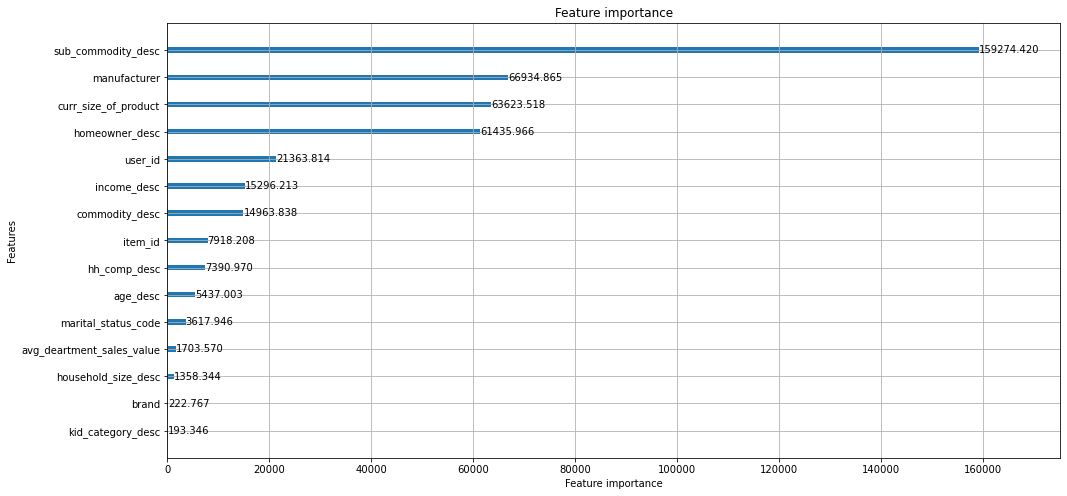

In [34]:
from lightgbm import plot_importance

plot_importance(gbm_model, figsize=(16, 8), importance_type='gain')

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 